In [1]:
import pandas as pd
from pandasql import sqldf
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_poisson_deviance
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge
from sklearn.experimental import enable_hist_gradient_boosting  
from sklearn.ensemble import HistGradientBoostingRegressor

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Data Preprocessing: Training Data

1. Import full dataset of the rides data of 2019 as the traing set. (Refer to "DataPipeline.ipynb" for details)
1. Filter out all samples without trips.
1. Filter out samples with average duration longer than 120 min (7200 sec) or less than 2 min (120 sec).

In [3]:
all_data = pd.read_csv("all_trips_2019.csv")

In [4]:
# define a function that takes the entire dataset and returns X variables and Y variables for model training
def preprocess(all_data):
    """
    Function takes full dataset and returns:
    
    * data: a dataframe with non-zero trip entries and average duration
            betwenn 120 sec and 7200 sec.
            
    * X_enc: X varibles with one-hot-encoded categorical variables:'Start_cluster','End_cluster','Day','Weekday'
             and continuous variables:'AVG_Duration'.
             
    * y: predicting varibel 'trips'.
    """
    # filter out non-zero trip entries
    data = all_data[all_data['trips']!= 0]
    
    # filter out samples with average duration longer than 120 min (7200 sec) or less than 2 min (120 sec)
    data = data.loc[(data['AVG_Duration']<= 7200) & (data['AVG_Duration']>=120)]
    
    # reset index
    data = data.reset_index()
    
    # format date and days
    data_dup = data
    data_dup['Date'] = pd.to_datetime(data_dup['Date'])
    data_dup['Day'] = data_dup['Date'].dt.day
    
    # One Hot encoding categorical valriables and generate X and Y
    X = data_dup[['Start_cluster','End_cluster','Day','Weekday']]
    y = data_dup['trips']
    enc = OneHotEncoder(handle_unknown='ignore')
    X_enc = pd.DataFrame(enc.fit_transform(X).toarray())
    X_enc['AVG_Duration'] = data_dup['AVG_Duration']
    
    
    return data, X_enc, y

In [5]:
data2019, X_enc2019, y2019 = preprocess(all_data= all_data)

In [6]:
np.mean(data2019['trips'])

1.357698276009072

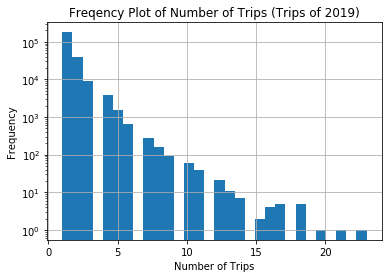

In [7]:
data2019['trips'].hist(bins = 30, log = True)
plt.xlabel('Number of Trips')
plt.ylabel('Frequency')
plt.title('Freqency Plot of Number of Trips (Trips of 2019)')
plt.show()

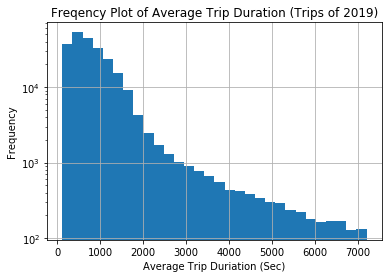

In [8]:
data2019['AVG_Duration'].hist(bins = 30, log = True)
plt.xlabel('Average Trip Duriation (Sec)')
plt.ylabel('Frequency')
plt.title('Freqency Plot of Average Trip Duration (Trips of 2019)')
plt.show()

## Random Forest Regressor

In [9]:
regRF = RandomForestRegressor(n_jobs=-1)
regRF.fit(X_enc2019, y2019)

RandomForestRegressor(n_jobs=-1)

In [10]:
regRF.score(X_enc2019,y2019)

0.843295421719707

In [11]:
y2019_pred = regRF.predict(X_enc2019)

In [12]:
print("MSE for training data is",mean_squared_error(y2019,y2019_pred))
print("MAE for training data is", mean_absolute_error(y2019,y2019_pred))
mask = y2019_pred > 0
print("mean Poisson deviance for training data is",
          mean_poisson_deviance(y2019[mask],
                                y2019_pred[mask],
                                ))

MSE for training data is 0.1097937912513589
MAE for training data is 0.18367617852872065
mean Poisson deviance for training data is 0.04626571825514716


### Test data: 2020 Jan, Feb, Mar

In [13]:
all_data_2020 = pd.read_csv("all_trips_2020.csv")

In [14]:
data2020, X_enc2020, y2020 = preprocess(all_data_2020)

In [15]:
data2020.head(5)

,index,TRIP_KEY,Start_ids,End_ids,Start_station,Start_cluster,End_station,End_cluster,Date,AVG_Duration,Month,Weekday,trips,Day
0,262,262,31253,31101,19th & K St NW,8,14th & V St NW,2,2020-01-01,569.0,1,Wednesday,1.0,1
1,293,293,31253,31110,19th & K St NW,8,20th St & Florida Ave NW,2,2020-01-01,449.0,1,Wednesday,1.0,1
2,299,299,31253,31212,19th & K St NW,8,New Hampshire Ave & Ward Pl NW,0,2020-01-01,233.0,1,Wednesday,1.0,1
3,501,501,31253,31648,19th & K St NW,8,Potomac Ave & Half St SW,1,2020-01-01,1301.0,1,Wednesday,1.0,1
4,649,649,31254,31509,15th & K St NW,8,New Jersey Ave & R St NW,2,2020-01-01,468.0,1,Wednesday,1.0,1


In [16]:
y2020_pred = regRF.predict(X_enc2020)

In [17]:
print("MSE for training data is",mean_squared_error(y2020,y2020_pred))
print("MAE for training data is", mean_absolute_error(y2020,y2020_pred))
mask = y2020_pred > 0
print("mean Poisson deviance for training data is",
          mean_poisson_deviance(y2020[mask],
                                y2020_pred[mask],
                                ))

MSE for training data is 0.4157339446728014
MAE for training data is 0.3939229905016677
mean Poisson deviance for training data is 0.22893610265817338


## Dummy Regressor

In [26]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_enc2019, y2019)

DummyRegressor()

In [27]:
y2019_pred_Dummy = dummy_regr.predict(X_enc2019)
print("MSE for training data is",mean_squared_error(y2019,y2019_pred_Dummy))
print("MAE for training data is", mean_absolute_error(y2019,y2019_pred_Dummy))
mask = y2019_pred_Dummy > 0
print("mean Poisson deviance for training data is",
          mean_poisson_deviance(y2019[mask],
                                y2019_pred_Dummy[mask],
                                ))

MSE for training data is 0.7006418858737735
MAE for training data is 0.5469533151249336
mean Poisson deviance for training data is 0.3497100673386463


### Test Data: 2020 Jan, Feb, Mar

In [28]:
y2020_pred_Dummy = dummy_regr.predict(X_enc2020)
print("MSE for training data is",mean_squared_error(y2020,y2020_pred_Dummy))
print("MAE for training data is", mean_absolute_error(y2020,y2020_pred_Dummy))
mask = y2020_pred_Dummy > 0
print("mean Poisson deviance for training data is",
          mean_poisson_deviance(y2020[mask],
                                y2020_pred_Dummy[mask],
                                ))

MSE for training data is 0.35945866122507547
MAE for training data is 0.462041607252867
mean Poisson deviance for training data is 0.21490752303381103


## Ridge Regression

In [31]:
ridge_regr = Ridge(alpha=1e-6)
ridge_regr.fit(X_enc2019,y2019)

Ridge(alpha=1e-06)

In [32]:
y2019_pred_ridge = ridge_regr.predict(X_enc2019)
print("MSE for training data is",mean_squared_error(y2019,y2019_pred_ridge))
print("MAE for training data is", mean_absolute_error(y2019,y2019_pred_ridge))
mask = y2019_pred_ridge > 0
print("mean Poisson deviance for training data is",
          mean_poisson_deviance(y2019[mask],
                                y2019_pred_ridge[mask],
                                ))

MSE for training data is 0.6538222524170395
MAE for training data is 0.5114868427726158
mean Poisson deviance for training data is 0.32098612011480815


### Test Data: 2020 Jan, Feb, Mar

In [33]:
y2020_pred_ridge = ridge_regr.predict(X_enc2020)
print("MSE for training data is",mean_squared_error(y2020,y2020_pred_ridge))
print("MAE for training data is", mean_absolute_error(y2020,y2020_pred_ridge))
mask = y2020_pred_ridge > 0
print("mean Poisson deviance for training data is",
          mean_poisson_deviance(y2020[mask],
                                y2020_pred_ridge[mask],
                                ))

MSE for training data is 0.35568798759104187
MAE for training data is 0.42697079293224177
mean Poisson deviance for training data is 0.21160779811151714


## Poisson Regression

In [36]:
from sklearn.linear_model import PoissonRegressor

poisson_regr = PoissonRegressor(alpha=1e-6, max_iter=100)
poisson_regr.fit(X_enc2019,y2019)

y2019_pred_poisson = poisson_regr.predict(X_enc2019)
print("MSE for training data is",mean_squared_error(y2019,y2019_pred_poisson))
print("MAE for training data is", mean_absolute_error(y2019,y2019_pred_poisson))
mask = y2019_pred_poisson > 0
print("mean Poisson deviance for training data is",
          mean_poisson_deviance(y2019[mask],
                                y2019_pred_poisson[mask],
                                ))

y2020_pred_poisson =poisson_regr.predict(X_enc2020)
print("MSE for training data is",mean_squared_error(y2020,y2020_pred_poisson))
print("MAE for training data is", mean_absolute_error(y2020,y2020_pred_poisson))
mask = y2020_pred_poisson > 0
print("mean Poisson deviance for training data is",
          mean_poisson_deviance(y2020[mask],
                                y2020_pred_poisson[mask],
                                ))

MSE for training data is 0.7006418858737735
MAE for training data is 0.546953315124934
mean Poisson deviance for training data is 0.3497100673386464
MSE for training data is 0.3594586612250757
MAE for training data is 0.4620416072528676
mean Poisson deviance for training data is 0.21490752303381122
MSE for training data is 0.35015705630400673
MAE for training data is 0.4596109832777867
mean Poisson deviance for training data is 0.21115793908745029
MSE for training data is 0.3849499210800921
MAE for training data is 0.46870278754211814
mean Poisson deviance for training data is 0.2251833431246413


## Histogram-based Gradient Boosting Regression Tree

In [37]:
est = HistGradientBoostingRegressor(loss="least_squares",max_leaf_nodes=128)
est.fit(X_enc2019,y2019)

HistGradientBoostingRegressor(max_leaf_nodes=128)

In [38]:
y2019_pred_est = est.predict(X_enc2019)
print("MSE for training data is",mean_squared_error(y2019,y2019_pred_est))
print("MAE for training data is", mean_absolute_error(y2019,y2019_pred_est))
mask = y2019_pred_est > 0
print("mean Poisson deviance for training data is",
          mean_poisson_deviance(y2019[mask],
                                y2019_pred_est[mask],
                                ))

MSE for training data is 0.6069268349179646
MAE for training data is 0.4926516668945993
mean Poisson deviance for training data is 0.2940352466489921


### Test Data: 2020 Jan, Feb, Mar

In [39]:
y2020_pred_est = est.predict(X_enc2020)
print("MSE for training data is",mean_squared_error(y2020,y2020_pred_est))
print("MAE for training data is", mean_absolute_error(y2020,y2020_pred_est))
mask = y2020_pred_est > 0
print("mean Poisson deviance for training data is",
          mean_poisson_deviance(y2020[mask],
                                y2020_pred_est[mask],
                                ))

MSE for training data is 0.3395592793040624
MAE for training data is 0.41699392520778517
mean Poisson deviance for training data is 0.19783280167857173


## Export Data in CSV files

In [53]:
results_2019 = pd.DataFrame(data = [np.array(y2019),y2019_pred_ridge,y2019_pred_poisson,y2019_pred,y2019_pred_est]).T

In [54]:
results_2019.columns = ['Data(Training)','Ridge(Training)','Poisson (Training)','Random Forest(Training)',  'HistGradBoosting(Training)' ]

In [55]:
results_2019.head(5)

,Data(Training),Ridge(Training),Poisson (Training),Random Forest(Training),HistGradBoosting(Training)
0,5.0,1.217827,1.357698,3.650000,1.251245
1,1.0,1.245581,1.357698,1.120000,1.343598
2,1.0,1.317996,1.357698,1.180000,1.295438
3,1.0,1.354025,1.357698,1.060000,1.181715
4,1.0,1.184596,1.357698,1.066667,1.243350


In [57]:
results_2020 = pd.DataFrame(data = [np.array(y2020),y2020_pred_ridge,y2020_pred_poisson, y2020_pred, y2020_pred_est,
                                    np.array(y2020_JF), y2020_pred_JF_ridge, y2020_pred_JF_poisson, y2020_JF_pred,  y2020_pred_JF_est,
                                    np.array(y2020_M), y2020_pred_M_ridge, y2020_pred_M_poisson, y2020_M_pred,  y2020_pred_M_est
                                    ]).T

In [58]:
results_2020.columns = ['Data(Full)', 'Ridge(Full)', 'Poisson(Full)', 'Random Forest(Full)',  'HistGradBoosting(Full)',
                       'Data(Jan&Feb)', 'Ridge(Jan&Feb)', 'Poisson(Jan&Feb)', 'Random Forest(Jan&Feb)',  'HistGradBoosting(Jan&Feb)',
                       'Data(March)', 'Ridge(March)', 'Poisson(March)','Random Forest(March)', 'HistGradBoosting(March)']

In [59]:
results_2020.head(5)

,Data(Full),Ridge(Full),Poisson(Full),Random Forest(Full),HistGradBoosting(Full),Data(Jan&Feb),Ridge(Jan&Feb),Poisson(Jan&Feb),Random Forest(Jan&Feb),HistGradBoosting(Jan&Feb),Data(March),Ridge(March),Poisson(March),Random Forest(March),HistGradBoosting(March)
0,1.0,1.236678,1.357698,1.140,1.350477,1.0,1.236678,1.357698,1.140,1.350477,1.0,1.584966,1.357698,1.22,1.848947
1,1.0,1.217226,1.357698,2.600,1.456769,1.0,1.217226,1.357698,2.600,1.456769,1.0,1.568507,1.357698,1.09,1.609459
2,1.0,1.155017,1.357698,1.190,1.231539,1.0,1.155017,1.357698,1.190,1.231539,1.0,1.635584,1.357698,2.33,2.022528
3,1.0,1.363632,1.357698,1.015,1.213190,1.0,1.363632,1.357698,1.015,1.213190,1.0,1.451115,1.357698,1.06,1.322268
4,1.0,1.220306,1.357698,1.350,1.398414,1.0,1.220306,1.357698,1.350,1.398414,1.0,1.364393,1.357698,1.04,1.286630


In [60]:
#results_2019.to_csv("results_2019.csv", index = False) 
#results_2020.to_csv('results_2020.csv', index = False)

### Plot predictions on the training dataset

In [61]:
#results_2019 = pd.read_csv('results_2019.csv')

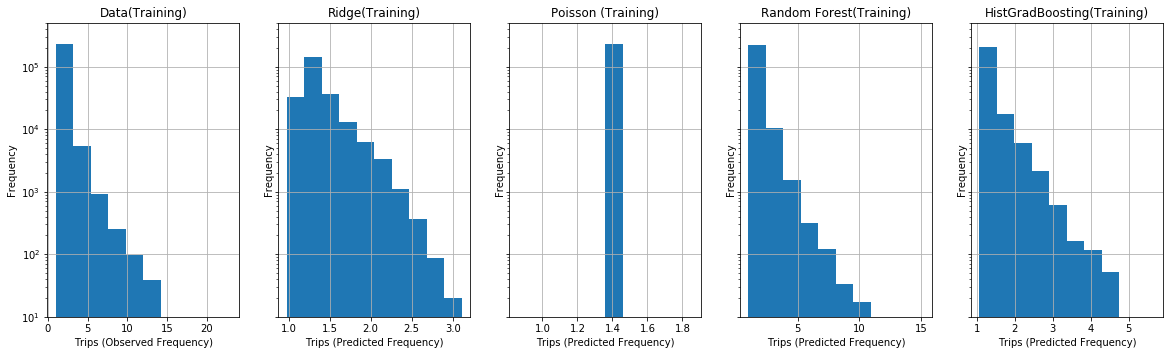

In [62]:
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20, 6), sharey=True)
fig.subplots_adjust(bottom=0.2)
# n_bins = 20
names = list(results_2019.columns)


for j in range(0,5):

    axs[j].hist(results_2019.iloc[:,j])
    axs[j].set_title(names[j])
    axs[j].set_yscale('log')
    axs[j].set_ylim([1e1, 5e5])
    axs[j].set_ylabel('Frequency')
    axs[j].grid(True)
    if j == 0:
        axs[j].set_xlabel("Trips (Observed Frequency)")
    else:
        axs[j].set_xlabel("Trips (Predicted Frequency)")

### Plot predictions on the testing datasets

In [63]:
#results_2020 = pd.read_csv('results_2020.csv')

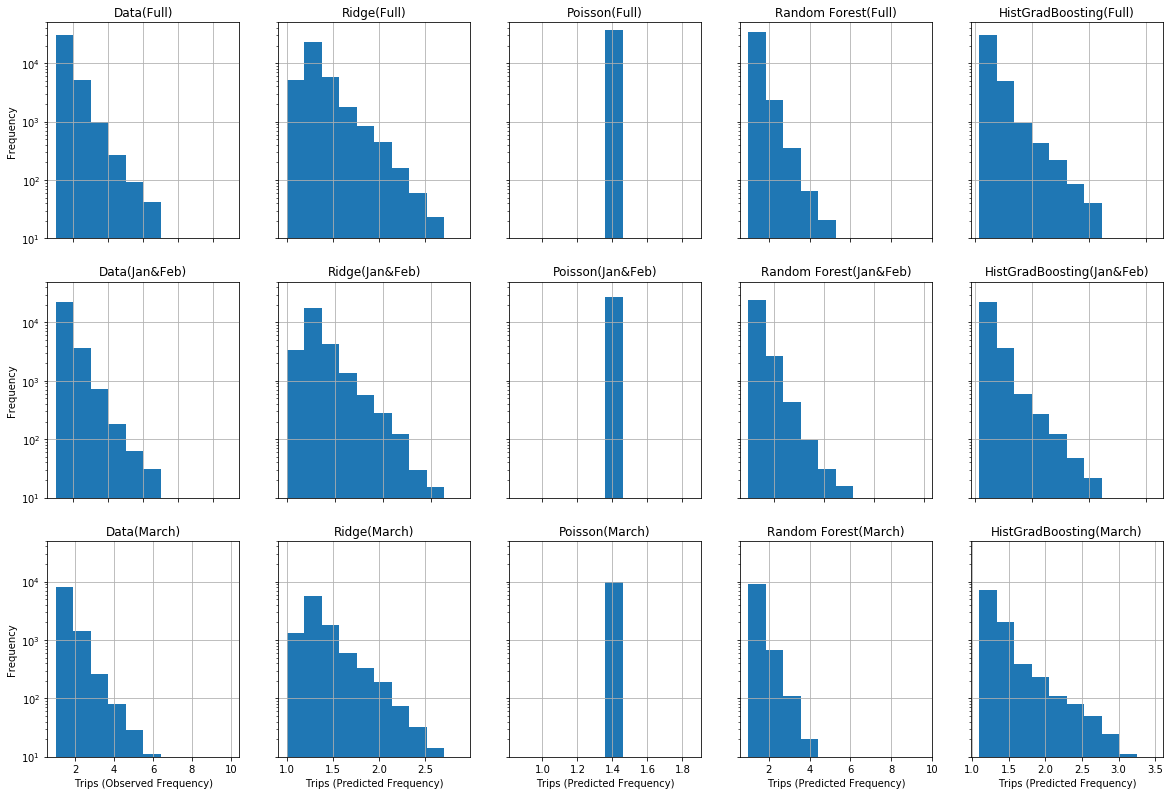

In [64]:
fig, axs = plt.subplots(nrows=3, ncols=5, figsize=(20, 15), sharey=True)
fig.subplots_adjust(bottom=0.2)
# n_bins = 20
names = list(results_2020.columns)

for j in range(0,5):
        
    index = i*5+j
    axs[i,j].hist(results_2020.iloc[:,index])
    axs[i,j].set_title(names[index])
    axs[i,j].set_yscale('log')
    axs[i, j].set_ylim([1e1, 5e4])
    axs[i,j].set_ylabel('Frequency')
    axs[i,j].grid(True)
    if j == 0:
        axs[i, j].set_xlabel("Trips (Observed Frequency)")
    else:
        axs[i, j].set_xlabel("Trips (Predicted Frequency)")

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()